# Using Article Embeddings to model Asset Returns: Informer

Multistep forecasting.

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(
    Path.cwd().parents[0].as_posix()
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from accelerate import Accelerator
from gluonts.time_feature import time_features_from_frequency_str
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch.optim import AdamW
from transformers import InformerConfig
from tqdm.auto import tqdm

from finnews.datasets import InformerFusionDataset
from finnews.models import InformerFusionModel
from finnews.models.train import train_informer_fusion

In [2]:
accelerator = Accelerator()
device = accelerator.device

# Defines

In [3]:
root_input_dir = os.path.join("data", "processed")

train_start = "2010-01-01"
val_start = "2023-06-01"
test_start = "2023-09-01"

holding_period = 14

# Data

## Raw

In [4]:
df_prices = pd.read_parquet(
    os.path.join(root_input_dir, "prices.parquet")
).sort_values(
    by=["symbol", "date"],
    ignore_index=True
)

In [5]:
df_articles_meta = pd.read_parquet(
    os.path.join(root_input_dir, "articles.parquet"),
    columns=["date", "symbol", "article"]
)

In [6]:
articles = torch.load(
    os.path.join(root_input_dir, "embeddings.pt"),
    weights_only=True,
    map_location=device
)

In [7]:
# The number of articles should equal to the number of embeddings
assert (df_articles_meta.shape[0] == articles.shape[0])

## Returns

Open-to-open next day ahead log returns:

- Strategy implies we buy and sell on market open (simplifying assumption)
- Easier for multiscale (just add up returns)
- Returns on non-business days are 0 (model will handle this via time embeddings)
- Trimming to coinside with the start of articles

In [8]:
df_ret = df_prices[["date", "symbol"]].copy()

# you buy today
df_ret["ret"] = -np.log(df_prices["open"])
# you sell tomorrow
df_ret["ret"] += np.log(df_prices.groupby('symbol')["open"].shift(-1))

In [9]:
# Adding non-business days and setting their returns to 0
df_ret = df_ret.set_index(
    ['symbol', 'date']
).sort_index().groupby(
    level="symbol"
).apply(
    lambda x: x.reset_index(
        level="symbol", 
        drop=True
    ).reindex(
        pd.date_range(
            start=x.index.get_level_values("date").min(),
            end=x.index.get_level_values("date").max(),
        ),
        level="date"
    ),
)

df_ret["bus_day"] = df_ret["ret"].notna().astype(int)  # Mask for 
df_ret["ret"] = df_ret["ret"].fillna(0)

df_ret.index.rename([df_ret.index.names[0], "date"], inplace=True)
df_ret = df_ret.reset_index()

In [10]:
# Trimming to articles
start_dates = df_articles_meta.groupby(
    "symbol"
)["date"].min().to_dict()

df_ret = df_ret.groupby('symbol', as_index=True).apply(
    lambda x: x.loc[x["date"] >= start_dates[x.name]],
    include_groups=False
).droplevel(level=-1).reset_index()

## Articles

- Multiple articles on any given day are averaged
- Timestamps are shifted forward to align with returns
- Zero embedding is used to denote days where there were no news articles

In [11]:
df_articles_meta_agg = df_articles_meta.groupby(
    ["date", "symbol"]
).apply(
    lambda x: x.index.tolist(), 
    include_groups=False
).to_frame(
    "indices"
).reset_index()

df_articles_meta_agg = df_articles_meta_agg.sort_values(
    ["symbol", "date"],
    ignore_index=True
)

# We can respond to today's news tomorrow
df_articles_meta_agg["date"] += pd.Timedelta("1d")

# Conforming to df_ret
df_articles_meta_agg = df_articles_meta_agg.set_index(
    ["symbol", "date"]
)
df_articles_meta_agg = df_articles_meta_agg.reindex(
    df_ret.set_index(["symbol", "date"]).index
)

In [12]:
# Should be the case
df_articles_meta_agg.shape[0] == df_ret.shape[0]

True

In [13]:
articles_agg = torch.stack(
    [
        articles[x].mean(axis=0) if ~np.isnan(x).all() else torch.zeros_like(articles[0])
        for x in df_articles_meta_agg["indices"].tolist()
    ],
    axis=0
)

# Model Config

In [14]:
prediction_length = holding_period
context_length = 64 # How many articles from the past we are using
distribution_output = "normal"
input_size = 1  # Univariate model
lags_sequence = [1]  # Not adding lags as additional features
scaling = None  # Data is already scaled
d_model = articles.shape[-1]  # Ease of use 
freq = "1d"

dropout = 0.2
encoder_layers = 4
decoder_layers = 4
num_parallel_samples = 25

In [15]:
time_features = time_features_from_frequency_str(freq)

In [16]:
model_config = InformerConfig(
    prediction_length=holding_period,
    context_length=context_length,
    input_size=input_size,
    lags_sequence=lags_sequence,
    scaling=scaling,
    num_time_features=len(time_features) + 1,
    dropout=dropout,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    d_model=d_model,
    distribution_output=distribution_output,
    num_parallel_samples=num_parallel_samples
)

# Data

In [17]:
batch_size = 64

In [18]:
idc = InformerFusionDataset(
    input_size=input_size,
    d_model=d_model,
    context_length=context_length,
    prediction_length=prediction_length,
    dropout=dropout,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    lags_sequence=lags_sequence,
    distribution_output=distribution_output,
    scaling=scaling,
    freq=freq
)

In [19]:
ds_train = idc.create_dataloader(
    df=df_ret.loc[
        df_ret["date"] < val_start
    ],
    articles_agg=articles_agg,
    mode="train",
    num_instances=2_000,
    batch_size=batch_size
)

ds_val = idc.create_dataloader(
    df=df_ret.loc[
        (df_ret["date"] >= val_start)
        & (df_ret["date"] < test_start)
    ],
    articles_agg=articles_agg,
    mode="validation",
    batch_size=batch_size
)

ds_test = idc.create_dataloader(
    df=df_ret.loc[
        (df_ret["date"] >= test_start)
    ],
    articles_agg=articles_agg,
    mode="test",
    batch_size=batch_size
)

# Model: `InformerFusionModel`

A modified implementation of `InformerForPrediction` from `transformers` package:
- Adds an option to feed article embeddings.

In [20]:
model = InformerFusionModel(
    config=model_config
)

In [21]:
epochs = 50

cur_timestamp = pd.Timestamp.now().strftime('%d_%m_%Y_%H_%M_%S')
model_save_dir = os.path.join(
    "models",
    "InformerFusion",
    cur_timestamp
)
os.makedirs(model_save_dir, exist_ok=True)

In [22]:
optimizer = AdamW(model.parameters(), lr=5e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [24]:
train_informer_fusion(
    model=model,
    optimizer=optimizer,
    dataloader_train=ds_train,
    dataloader_val=ds_val,
    save_dir=model_save_dir,
    epochs=epochs
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [1/50], Train Loss: 5.4304, Val Accuracy: 0.4913, Val MAE Loss: 0.0366, Precision: 0.4545, Recall: 0.2107, F1: 0.2879, ROC AUC: 0.4848


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [2/50], Train Loss: 0.3427, Val Accuracy: 0.4881, Val MAE Loss: 0.0497, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [3/50], Train Loss: -0.3821, Val Accuracy: 0.5000, Val MAE Loss: 0.0159, Precision: 0.4935, Recall: 0.9222, F1: 0.6429, ROC AUC: 0.5098


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [4/50], Train Loss: -0.7310, Val Accuracy: 0.4889, Val MAE Loss: 0.0162, Precision: 0.4885, Recall: 1.0000, F1: 0.6564, ROC AUC: 0.5008


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [5/50], Train Loss: -0.7791, Val Accuracy: 0.5222, Val MAE Loss: 0.0139, Precision: 0.5080, Recall: 0.6694, F1: 0.5776, ROC AUC: 0.5256


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [6/50], Train Loss: -1.0568, Val Accuracy: 0.5190, Val MAE Loss: 0.0128, Precision: 0.5047, Recall: 0.7780, F1: 0.6122, ROC AUC: 0.5250


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [7/50], Train Loss: -0.9540, Val Accuracy: 0.5150, Val MAE Loss: 0.0135, Precision: 0.8333, Recall: 0.0081, F1: 0.0161, ROC AUC: 0.5033


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [8/50], Train Loss: -0.7981, Val Accuracy: 0.5206, Val MAE Loss: 0.0128, Precision: 0.5057, Recall: 0.7925, F1: 0.6174, ROC AUC: 0.5269


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [9/50], Train Loss: -0.9480, Val Accuracy: 0.4881, Val MAE Loss: 0.0177, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [10/50], Train Loss: -1.1023, Val Accuracy: 0.4881, Val MAE Loss: 0.0147, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [11/50], Train Loss: -1.0738, Val Accuracy: 0.4858, Val MAE Loss: 0.0135, Precision: 0.4869, Recall: 0.9919, F1: 0.6531, ROC AUC: 0.4975


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [12/50], Train Loss: -0.9059, Val Accuracy: 0.4881, Val MAE Loss: 0.0171, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [13/50], Train Loss: -1.1188, Val Accuracy: 0.4881, Val MAE Loss: 0.0162, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [14/50], Train Loss: -1.0887, Val Accuracy: 0.4881, Val MAE Loss: 0.0139, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [15/50], Train Loss: -1.1950, Val Accuracy: 0.5119, Val MAE Loss: 0.0156, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [16/50], Train Loss: -1.2411, Val Accuracy: 0.5261, Val MAE Loss: 0.0126, Precision: 0.5287, Recall: 0.2690, F1: 0.3566, ROC AUC: 0.5201


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [17/50], Train Loss: -1.1502, Val Accuracy: 0.5008, Val MAE Loss: 0.0128, Precision: 0.4943, Recall: 0.9903, F1: 0.6595, ROC AUC: 0.5121


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [18/50], Train Loss: -1.2725, Val Accuracy: 0.4921, Val MAE Loss: 0.0126, Precision: 0.4897, Recall: 0.9676, F1: 0.6503, ROC AUC: 0.5031


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [19/50], Train Loss: -1.0948, Val Accuracy: 0.4881, Val MAE Loss: 0.0140, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [20/50], Train Loss: -1.1965, Val Accuracy: 0.4881, Val MAE Loss: 0.0145, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [21/50], Train Loss: -1.3308, Val Accuracy: 0.4826, Val MAE Loss: 0.0125, Precision: 0.4846, Recall: 0.9417, F1: 0.6399, ROC AUC: 0.4932


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [22/50], Train Loss: -1.2071, Val Accuracy: 0.4889, Val MAE Loss: 0.0133, Precision: 0.4885, Recall: 1.0000, F1: 0.6564, ROC AUC: 0.5008


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [23/50], Train Loss: -1.2346, Val Accuracy: 0.5142, Val MAE Loss: 0.0132, Precision: 1.0000, Recall: 0.0049, F1: 0.0097, ROC AUC: 0.5024


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [24/50], Train Loss: -1.0962, Val Accuracy: 0.5222, Val MAE Loss: 0.0124, Precision: 0.5236, Recall: 0.2334, F1: 0.3229, ROC AUC: 0.5155


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [25/50], Train Loss: -1.2852, Val Accuracy: 0.5119, Val MAE Loss: 0.0136, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [26/50], Train Loss: -1.2627, Val Accuracy: 0.4881, Val MAE Loss: 0.0145, Precision: 0.4881, Recall: 1.0000, F1: 0.6560, ROC AUC: 0.5000


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [27/50], Train Loss: -1.2410, Val Accuracy: 0.4818, Val MAE Loss: 0.0124, Precision: 0.4808, Recall: 0.7731, F1: 0.5929, ROC AUC: 0.4886


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [28/50], Train Loss: -1.2881, Val Accuracy: 0.5119, Val MAE Loss: 0.0147, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [29/50], Train Loss: -1.2952, Val Accuracy: 0.5119, Val MAE Loss: 0.0126, Precision: 0.5000, Recall: 0.0227, F1: 0.0434, ROC AUC: 0.5005


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [30/50], Train Loss: -1.3061, Val Accuracy: 0.4937, Val MAE Loss: 0.0125, Precision: 0.4906, Recall: 0.9692, F1: 0.6514, ROC AUC: 0.5047


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [31/50], Train Loss: -1.2663, Val Accuracy: 0.4873, Val MAE Loss: 0.0130, Precision: 0.4877, Recall: 0.9984, F1: 0.6553, ROC AUC: 0.4992


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [32/50], Train Loss: -1.3176, Val Accuracy: 0.5119, Val MAE Loss: 0.0142, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [33/50], Train Loss: -1.2789, Val Accuracy: 0.5024, Val MAE Loss: 0.0122, Precision: 0.4868, Recall: 0.3582, F1: 0.4127, ROC AUC: 0.4990


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [34/50], Train Loss: -1.2710, Val Accuracy: 0.5111, Val MAE Loss: 0.0127, Precision: 0.4286, Recall: 0.0049, F1: 0.0096, ROC AUC: 0.4993


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [35/50], Train Loss: -1.3209, Val Accuracy: 0.5127, Val MAE Loss: 0.0124, Precision: 0.5217, Recall: 0.0194, F1: 0.0375, ROC AUC: 0.5012


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [36/50], Train Loss: -1.1928, Val Accuracy: 0.4810, Val MAE Loss: 0.0122, Precision: 0.4824, Recall: 0.8639, F1: 0.6190, ROC AUC: 0.4899


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [37/50], Train Loss: -1.2897, Val Accuracy: 0.5364, Val MAE Loss: 0.0121, Precision: 0.5201, Recall: 0.6499, F1: 0.5778, ROC AUC: 0.5390


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [38/50], Train Loss: -1.2941, Val Accuracy: 0.5119, Val MAE Loss: 0.0125, Precision: 0.5000, Recall: 0.0097, F1: 0.0191, ROC AUC: 0.5002


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [39/50], Train Loss: -1.4292, Val Accuracy: 0.4881, Val MAE Loss: 0.0127, Precision: 0.4881, Recall: 0.9951, F1: 0.6549, ROC AUC: 0.4999


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [40/50], Train Loss: -1.2706, Val Accuracy: 0.4945, Val MAE Loss: 0.0124, Precision: 0.4903, Recall: 0.9011, F1: 0.6351, ROC AUC: 0.5039


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [41/50], Train Loss: -1.3890, Val Accuracy: 0.5119, Val MAE Loss: 0.0156, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [42/50], Train Loss: -1.2856, Val Accuracy: 0.4881, Val MAE Loss: 0.0122, Precision: 0.4860, Recall: 0.8412, F1: 0.6160, ROC AUC: 0.4963


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [43/50], Train Loss: -1.3563, Val Accuracy: 0.5119, Val MAE Loss: 0.0125, Precision: 0.5000, Recall: 0.0097, F1: 0.0191, ROC AUC: 0.5002


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [44/50], Train Loss: -1.2292, Val Accuracy: 0.5111, Val MAE Loss: 0.0127, Precision: 0.3333, Recall: 0.0016, F1: 0.0032, ROC AUC: 0.4993


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [45/50], Train Loss: -1.2680, Val Accuracy: 0.5119, Val MAE Loss: 0.0134, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.5000


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [46/50], Train Loss: -1.3291, Val Accuracy: 0.5079, Val MAE Loss: 0.0122, Precision: 0.4828, Recall: 0.1135, F1: 0.1837, ROC AUC: 0.4988


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch [47/50], Train Loss: -1.3474, Val Accuracy: 0.4937, Val MAE Loss: 0.0125, Precision: 0.4906, Recall: 0.9741, F1: 0.6526, ROC AUC: 0.5048
Early stopping triggered.


## Test Dataset

Performance on test set per asset. Marginally better than the baseline model.

In [25]:
# Reloading the best model
chkpoint = torch.load(
    os.path.join(model_save_dir, "best_model.pt"), 
    map_location=device,
    weights_only=False
)

model_dict = model.state_dict()

model_dict.update(chkpoint)
model.load_state_dict(model_dict)
_ = model.to(device)

In [26]:
# Dataframe with test results
df_test = pd.DataFrame()

In [27]:
for batch in tqdm(ds_test):
    outputs = model.generate(
        past_time_features=torch.Tensor(batch["past_time_features"]).to(device),
        past_values=torch.Tensor(batch["past_values"]).to(device),
        inputs_fusion=torch.Tensor(batch["past_articles"]).to(device),
        future_time_features=torch.Tensor(batch["future_time_features"]).to(device),
    )

    # Signs of forecasts
    outputs_signs = torch.quantile(
        torch.sign(torch.sum(outputs["sequences"], axis=-1)),
        q=0.5,
        dim=-1
    )
    outputs_signs = (outputs_signs > 0).int()
    true_signs = (torch.sign(torch.sum(torch.Tensor(batch["future_values"]), axis=-1)) > 0).int()

    cur_df = pd.DataFrame(
        {
            "date": batch['forecast_start'] + pd.Timedelta(f'{context_length + prediction_length + 1}d'),
            "symbol": batch['item_id'],
            "y": true_signs.numpy(),
            "y_pred": outputs_signs.cpu().numpy(),
        }
    )
    df_test = pd.concat([df_test, cur_df])

0it [00:00, ?it/s]

In [28]:
df_test["match"] = (df_test["y"] == df_test["y_pred"])

In [29]:
print(f"Overall Model Accuracy: {df_test["match"].mean()}")

Overall Model Accuracy: 0.5416666666666666


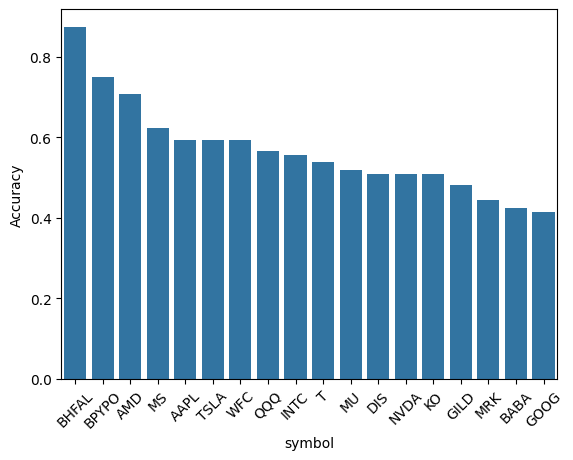

In [30]:
df_plot = df_test.groupby("symbol")["match"].agg(
    ["count", "mean"]
).rename(columns={"mean": "Accuracy"}).sort_values(
    by="Accuracy", ascending=False
)

sns.barplot(
    data=df_plot.reset_index(),
    x="symbol",
    y="Accuracy",
    order=df_plot.index,
)
plt.xticks(rotation=45)
plt.show()

In [31]:
summary_table = {
    "Metric": ["Precision", "Recall", "F1 Score", "ROC AUC"],
    "Overall": [
        precision_score(df_test["y"], df_test["y_pred"], zero_division=np.nan),
        recall_score(df_test["y"], df_test["y_pred"]),
        f1_score(df_test["y"], df_test["y_pred"]),
        roc_auc_score(df_test["y"], df_test["y_pred"])
    ]
}

for symbol, group in df_test.groupby("symbol"):
    try:
        cur_roc_auc = roc_auc_score(group["y"], group["y_pred"])
    except:
        cur_roc_auc = None
    
    summary_table[symbol] = [
        precision_score(group["y"], group["y_pred"], zero_division=np.nan),
        recall_score(group["y"], group["y_pred"]),
        f1_score(group["y"], group["y_pred"]),
        cur_roc_auc
    ]

df_summary = pd.DataFrame(summary_table)

In [32]:
df_summary

,Metric,Overall,AAPL,AMD,BABA,BHFAL,BPYPO,DIS,GILD,GOOG,INTC,KO,MRK,MS,MU,NVDA,QQQ,T,TSLA,WFC
0,Precision,0.594364,0.638554,0.783784,0.298701,1.000000,0.916667,0.518519,0.491803,0.470588,0.642857,0.560606,0.428571,0.657143,0.627119,0.528571,0.640000,0.671233,0.701299,0.738462
1,Recall,0.687068,0.803030,0.794521,0.766667,0.866667,0.785714,0.763636,0.555556,0.551724,0.671642,0.616667,0.687500,0.741935,0.560606,0.660714,0.716418,0.662162,0.729730,0.648649
2,F1 Score,0.637363,0.711409,0.789116,0.429907,0.928571,0.846154,0.617647,0.521739,0.507937,0.656934,0.587302,0.528000,0.696970,0.592000,0.587302,0.676056,0.666667,0.715232,0.690647
3,ROC AUC,0.511366,0.526515,0.654836,0.528070,0.933333,0.642857,0.499465,0.479701,0.400862,0.515308,0.493116,0.464440,0.598240,0.505303,0.500357,0.512055,0.456081,0.505490,0.558699


## Test Dataset - Individual Predictions

How the distribution of predictions looks like

In [33]:
batch = next(iter(ds_test))

In [34]:
outputs = model.generate(
    past_time_features=torch.Tensor(batch["past_time_features"]).to(device),
    past_values=torch.Tensor(batch["past_values"]).to(device),
    inputs_fusion=torch.Tensor(batch["past_articles"]).to(device),
    future_time_features=torch.Tensor(batch["future_time_features"]).to(device),
)

In [35]:
cur_idx = 20

In [36]:
sim_values = outputs["sequences"][cur_idx].cpu().numpy()

In [37]:
# Calculate quantiles
q10 = np.percentile(sim_values, 10, axis=0)
q25 = np.percentile(sim_values, 25, axis=0)
q50 = np.percentile(sim_values, 50, axis=0)
q75 = np.percentile(sim_values, 75, axis=0)
q90 = np.percentile(sim_values, 90, axis=0)
time = np.arange(sim_values.shape[1])

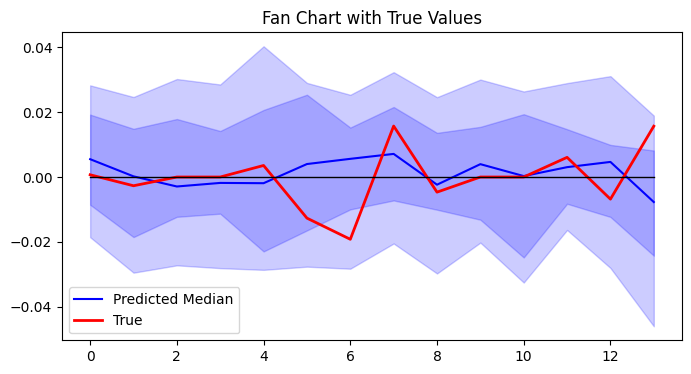

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(time, q10, q90, color='blue', alpha=0.2)
ax.fill_between(time, q25, q75, color='blue', alpha=0.2)
ax.plot(time, q50, color='blue', label='Predicted Median')
ax.plot(time, batch['future_values'][cur_idx], color='red', linewidth=2, label='True')
ax.plot(time, batch['future_values'][cur_idx] * 0, color='black', linewidth=1)
ax.set_title("Fan Chart with True Values")
ax.legend()
plt.show()